In [175]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os,sys
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

In [176]:
hlaPATH = "./Scrapper/hla_msa.txt"
afterPcaPATH = './after_pca.txt'
epitopePATH = './remove0123_sample100.csv'

In [177]:
after_pca = np.loadtxt(afterPcaPATH)

In [178]:
after_pca.shape

(21, 12)

In [179]:
ori = pd.read_csv(epitopePATH)

In [180]:
ori = ori.sample(frac=1, replace=False, random_state = 4).set_index(pd.Index(np.arange(ori.shape[0])))
ori.head()

,peptide,HLA,immunogenicity,test,respond,potential
0,DYIIKIWKL,HLA-A*2402,Negative,5,0,0.267811
1,VPVVEDALM,HLA-B*3501,Positive,0,0,0.969088
2,MMQDREDQSI,HLA-A*0201,Negative,24,0,0.108715
3,VEMTEPYNL,HLA-B*4402,Negative,4,0,0.294861
4,FIFSYVVAV,HLA-A*0201,Positive,0,0,0.973914


In [181]:
ori.shape

(8971, 6)

In [182]:
df = pd.read_csv(hlaPATH,header=None,delim_whitespace=True)
df.columns = ["HLA","pseudo"]

In [183]:
df

,HLA,pseudo
0,HLA-A*0101,--MY----------YQE--NMHT--DNTLYIYYR--D--Y-TKW--...
1,HLA-A*0201,---YMYTY--FM--YERKVAAHT--TVDTLYSRYHYY--IGTKWA-...
2,HLA-A*0203,---Y-Y---------EK--VAH---TVDTLYR-Y--Y--Y-TKW--...
3,HLA-A*0205,-------------YY-----YEKVVYD-----YY--R--D-TKW--...
4,HLA-A*0206,--MY-YM-------YEK--VAHQ--TVDTLYRYH--Y--Y-TKW--...
...,...,...
57,HLA-C*0517,-------------MY-----YEK-RQTNKLYRYN--F--Y-TKW--...
58,HLA-C*0602,-------------MYDS---YEKYRQADVNKLYW--Y--Y-TKW--...
59,HLA-C*0756,---Y-DFS------YRE--KYQ---AVSNLYRS---D--Y-TKL--...
60,HLA-C*1510,--MY-----FFM-YYYE----NMQTYVDTIYIYDSDYE--STKWV-...


In [184]:
hla_dic = {row["HLA"]:row["pseudo"] for index, row in df.iterrows()}

In [185]:
hla_dic["HLA-A*0101"]

'--MY----------YQE--NMHT--DNTLYIYYR--D--Y-TKW--VAQ-RYRGRYTQ-----D'

In [186]:
inventory = list(hla_dic.keys())

In [187]:
inventory[0]

'HLA-A*0101'

In [188]:
dic_inventory = {}
for hla in inventory:
    if hla[4] in dic_inventory:
        if hla[6:8] in dic_inventory[hla[4]]:
            dic_inventory[hla[4]][hla[6:8]].append(hla[8:])
        else:
            dic_inventory[hla[4]][hla[6:8]] =[]
            dic_inventory[hla[4]][hla[6:8]].append(hla[8:])
    else:
        dic_inventory[hla[4]] = {}
        dic_inventory[hla[4]][hla[6:8]] =[]
        dic_inventory[hla[4]][hla[6:8]].append(hla[8:])

In [189]:
# dic_inventory

In [190]:
def rescue_unknown_hla(hla, dic_inventory):
    type_ = hla[4]
    first2 = hla[6:8]
    last2 = hla[8:]
    big_category = dic_inventory[type_]
    #print(hla)
    if not big_category.get(first2) == None:
        small_category = big_category.get(first2)
        distance = [abs(int(last2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(first2) + str(optimal)
    else:
        small_category = list(big_category.keys())
        distance = [abs(int(first2) - int(i)) for i in small_category]
        optimal = min(zip(small_category, distance), key=lambda x: x[1])[0]
        return 'HLA-' + str(type_) + '*' + str(optimal) + str(big_category[optimal][0])

def aaindex(peptide,after_pca):

    amino = 'ARNDCQEGHILKMFPSTWYV-'
    matrix = np.transpose(after_pca)   # [12,21]
    encoded = np.empty([len(peptide), 12])  # (seq_len,12)
    for i in range(len(peptide)):
        query = peptide[i]
        if query == 'X': query = '-'
        query = query.upper()
        encoded[i, :] = matrix[:, amino.index(query)]

    return encoded

def hla_data_aaindex(hla_dic,hla_type,after_pca,dic_inventory):    # return numpy array [34,12,1]
    try:
        seq = hla_dic[hla_type]
    except KeyError:
        hla_type = rescue_unknown_hla(hla_type,dic_inventory)
        seq = hla_dic[hla_type]
    encode = aaindex(seq,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode

def peptide_data_aaindex(peptide,after_pca):   # return numpy array [10,12,1]
    length = len(peptide)
    if length == 10:
        encode = aaindex(peptide,after_pca)
    elif length == 9:
        peptide = peptide[:5] + '-' + peptide[5:]
        encode = aaindex(peptide,after_pca)
    encode = encode.reshape(encode.shape[0], encode.shape[1], -1)
    return encode


def construct_aaindex(ori,hla_dic,after_pca,dic_inventory):
    series = []
#     res = pd.DataFrame(columns = ['encode_pep', 'encode_hla', 'immuno'])
    for i in range(ori.shape[0]):
        peptide = ori['peptide'].iloc[i]
        hla_type = ori['HLA'].iloc[i]
        immuno = np.array(ori['potential'].iloc[i]).reshape(1,-1)   # [1,1]

        encode_pep = peptide_data_aaindex(peptide,after_pca)    # [10,12]

        encode_hla = hla_data_aaindex(hla_dic,hla_type,after_pca,dic_inventory)   # [64,12]
#         res.loc[i] = [encode_pep.reshape(10,12).astype(float), encode_hla.reshape(64,12).astype(float), immuno]
        series.append((encode_pep, encode_hla, immuno))
#     return res
    return series

In [191]:
# dataset = construct_aaindex(ori, hla_dic, after_pca,dic_inventory)
dataset = construct_aaindex(ori, hla_dic, after_pca,dic_inventory)

In [192]:
input1 = np.empty([len(dataset),10,12,1])
input2 = np.empty([len(dataset),64,12,1])
label = np.empty([len(dataset),1])

for i in range(len(dataset)):
    input1[i,:,:,:] = dataset[i][0]
    input2[i,:,:,:] = dataset[i][1]
    label[i,:] = dataset[i][2]


In [193]:
# dataset.shape

In [194]:
# X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['immuno'], axis=1), dataset["immuno"], test_size=0.1, random_state=4)

In [195]:
# input1_train = X_train["encode_pep"]
# input1_val = X_test["encode_pep"]
# input1_train[0].shape

In [196]:
# input1_train[0]

In [197]:
# tempdata = copy.deepcopy(input1_train[0])

In [198]:
# tempdata2 = copy.deepcopy(tempdata)

In [199]:
# input1_train.shape[0]

In [200]:
# tempdata

In [201]:
# temp_array = np.empty(input1_train.shape[0])
# for i in range(input1_train.shape[0]):
#     temp_array[i] = tf.convert_to_tensor(input1_train[i])
# temp_array

In [202]:
# input2_train = X_train["encode_hla"]
# input2_val = X_test["encode_hla"]
# input2_train[0].shape

In [203]:
# y_train = y_train.to_numpy().reshape(y_train.shape[0],-1)

In [204]:
# y_test = y_test.to_numpy().reshape(y_test.shape[0],-1)

In [205]:
# tf.convert_to_tensor(np.asarray(input1_train))

In [206]:
y_train.shape

(8073,)

In [207]:
# input1.shape

In [208]:
array = np.arange(len(dataset))
train_index = np.random.choice(array,int(len(dataset)*0.9),replace=False)
valid_index = [item for item in array if item not in train_index]
input1_train = input1[train_index]
input1_val = input1[valid_index]
input2_train = input2[train_index]
input2_val = input2[valid_index]
label_train = label[train_index]
label_val = label[valid_index]

In [209]:
# len(label_val)

In [213]:
def buildCNN():
    input_pep = keras.Input(shape=(10, 12, 1))
    input_mhc = keras.Input(shape=(64, 12, 1))

    x = layers.Conv2D(filters=16, kernel_size=(2, 12))(input_pep)  # 9
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Conv2D(filters=32, kernel_size=(2, 1))(x)    # 8
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(x)  # 4
    x = layers.Flatten()(x)
    x = keras.Model(inputs=input_pep, outputs=x)

    y = layers.Conv2D(filters=16, kernel_size=(33, 12))(input_mhc)     # 32
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(y)  # 16
    y = layers.Conv2D(filters=32,kernel_size=(9,1))(y)    # 8
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1),strides=(2,1))(y)  # 4
    y = layers.Flatten()(y)
    y = keras.Model(inputs=input_mhc,outputs=y)

    combined = layers.concatenate([x.output,y.output])
    z = layers.Dense(128,activation='relu')(combined)
    z = layers.Dropout(0.2)(z)
    z = layers.Dense(1,activation='sigmoid')(z)

    model = keras.Model(inputs=[input_pep,input_mhc],outputs=z)
    return model

In [214]:
# x=[tf.convert_to_tensor(input1_train),tf.convert_to_tensor(input2_train)]

In [215]:
# print(x)

In [226]:
cnn_model = buildCNN()
cnn_model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     metrics=['accuracy']
    )

callback_val = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=False)
callback_train = keras.callbacks.EarlyStopping(monitor='loss',patience=2,restore_best_weights=False)

history = cnn_model.fit(
    x=[input1_train,input2_train],   # feed a list into
    y=label_train,
    validation_data = ([input1_val,input2_val],label_val),
    batch_size=128,
    epochs=200,
#     class_weight = {0:0.5,1:0.5},   # I have 20% positive and 80% negative in my training data
    callbacks = [callback_val,callback_train]
    )

Epoch 1/200
64/64 [==============================] - 1s 9ms/step - loss: 0.1068 - val_loss: 0.1028
Epoch 2/200
64/64 [==============================] - 1s 8ms/step - loss: 0.0935 - val_loss: 0.0897
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0897 - val_loss: 0.0890
Epoch 4/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0874 - val_loss: 0.0841
Epoch 5/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0851 - val_loss: 0.0829
Epoch 6/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0848 - val_loss: 0.0817
Epoch 7/200
64/64 [==============================] - 0s 8ms/step - loss: 0.0829 - val_loss: 0.0815
Epoch 8/200
64/64 [==============================] - 0s 8ms/step - loss: 0.0826 - val_loss: 0.0811
Epoch 9/200
64/64 [==============================] - 0s 8ms/step - loss: 0.0815 - val_loss: 0.0811
Epoch 10/200
64/64 [==============================] - 0s 8ms/step - loss: 0.0807 - val_loss: 0.0809
Epoch 11/

In [ ]:
# x=[input1_train.reshape(input1_train.shape[0],-1),input2_train.reshape(input2_train.shape[0],-1)]

In [ ]:
# x[0].astype(float)

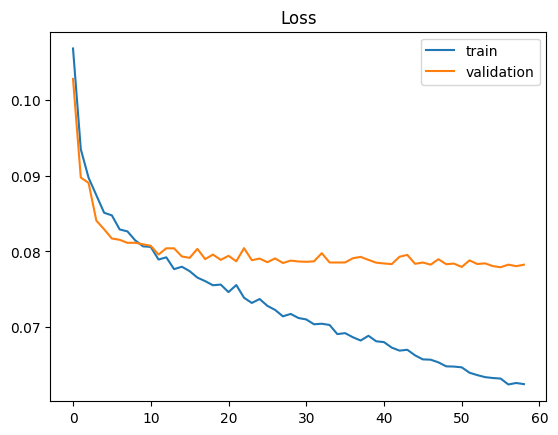

In [227]:
draw_history(history)

In [127]:
def draw_history(history):
    import matplotlib.pyplot as plt
    plt.plot()
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()

In [130]:
cnn_model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 64, 12, 1)]  0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 10, 12, 1)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 32, 1, 16)    6352        ['input_16[0][0]']               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 9, 1, 16)     400         ['input_15[0][0]']               
                                                                                           

In [228]:
# binary classification accuracy
predictions = cnn_model.predict([input1_val,input2_val])
predictions.shape

29/29 [==============================] - 0s 1ms/step


(898, 1)

In [232]:
exact_match = 0
for i in range(len(predictions)):
    if predictions[i]>0.5 and label_val[i]>0.5:
        exact_match+=1
    elif predictions[i]<=0.5 and label_val[i]<=0.5:
        exact_match+=1
    else:
        continue
print("Accuracy : ",exact_match/len(predictions))

Accuracy :  0.7728285077951003


In [239]:
def buildCNN2():
    input_pep = keras.Input(shape=(10, 12, 1))
    input_mhc = keras.Input(shape=(64, 12, 1))

    x = layers.Conv2D(filters=16, kernel_size=(2, 12))(input_pep)  # 9
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Conv2D(filters=32, kernel_size=(2, 1))(x)    # 8
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(x)  # 4
    x = layers.Flatten()(x)
    x = keras.Model(inputs=input_pep, outputs=x)

    y = layers.Conv2D(filters=16, kernel_size=(33, 12))(input_mhc)     # 32
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(y)  # 16
    y = layers.Conv2D(filters=32,kernel_size=(9,1))(y)    # 8
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1),strides=(2,1))(y)  # 4
    y = layers.Flatten()(y)
    y = keras.Model(inputs=input_mhc,outputs=y)

    combined = layers.concatenate([x.output,y.output])
    z = layers.Dense(128,activation='relu')(combined)
    z = layers.Dropout(0.2)(z)
    z = layers.Dense(1,activation='sigmoid')(z)

    model = keras.Model(inputs=[input_pep,input_mhc],outputs=z)
    return model

In [240]:
cnn_model2 = buildCNN2()
cnn_model2.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
#     metrics=['accuracy']
    )

callback_val = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=False)
callback_train = keras.callbacks.EarlyStopping(monitor='loss',patience=2,restore_best_weights=False)

history = cnn_model.fit(
    x=[input1_train,input2_train],   # feed a list into
    y=label_train,
    validation_data = ([input1_val,input2_val],label_val),
    batch_size=128,
    epochs=200,
#     class_weight = {0:0.5,1:0.5},   # I have 20% positive and 80% negative in my training data
    callbacks = [callback_val,callback_train]
    )

Epoch 1/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0606 - val_loss: 0.0785
Epoch 2/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0604 - val_loss: 0.0781
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0607 - val_loss: 0.0785
Epoch 4/200
64/64 [==============================] - 0s 7ms/step - loss: 0.0610 - val_loss: 0.0792


In [241]:
# binary classification accuracy
predictions2 = cnn_model2.predict([input1_val,input2_val])
# predictions2.shape
exact_match2 = 0
for i in range(len(predictions)):
    if predictions2[i]>0.5 and label_val[i]>0.5:
        exact_match2+=1
    elif predictions2[i]<=0.5 and label_val[i]<=0.5:
        exact_match2+=1
    else:
        continue
print("Accuracy : ",exact_match2/len(predictions2))

29/29 [==============================] - 0s 1ms/step
Accuracy :  0.5623608017817372


In [236]:
# draw_history(history)

In [ ]:
cnn_model = seperateCNN()
cnn_model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(lr=0.0001),
    metrics=['accuracy'])

callback_val = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=False)
callback_train = keras.callbacks.EarlyStopping(monitor='loss',patience=2,restore_best_weights=False)
history = cnn_model.fit(
    x=[input1_train,input2_train],   # feed a list into
    y=label_train,
    validation_data = ([input1_valid,input2_valid],label_valid),
    batch_size=128,
    epochs=200,
    class_weight = {0:0.5,1:0.5},   # I have 20% positive and 80% negative in my training data
    callbacks = [callback_val,callback_train])

In [ ]:
# input1 = np.empty([len(dataset),10,12,1])
# input2 = np.empty([len(dataset),64,12,1])
# label = np.empty([len(dataset),1])
# for i in range(len(dataset)):
#     input1[i,:,:,:] = dataset[i][0]
#     input2[i,:,:,:] = dataset[i][1]
#     label[i,:] = dataset[i][2]

In [ ]:
input1.shape

In [ ]:
input2.shape

In [ ]:
label.shape

In [ ]:
# hla_dic = hla_df_to_dic(hla)
# inventory = list(hla_dic.keys())
# dic_inventory = dict_inventory(inventory)
# dataset = construct_aaindex(ori, hla_dic, after_pca,dic_inventory)
# input1 = pull_peptide_aaindex(dataset)
# input2 = pull_hla_aaindex(dataset)
# label = pull_label_aaindex_continuous(dataset)

In [ ]:
def buildCNN():
    input_pep = keras.Input(shape=(10, 12, 1))
    input_mhc = keras.Input(shape=(64, 12, 1))

    x = layers.Conv2D(filters=16, kernel_size=(2, 12))(input_pep)  # 9
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Conv2D(filters=32, kernel_size=(2, 1))(x)    # 8
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(x)  # 4
    x = layers.Flatten()(x)
    x = keras.Model(inputs=input1, outputs=x)

    y = layers.Conv2D(filters=16, kernel_size=(15, 12))(input2)     # 32
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1), strides=(2, 1))(y)  # 16
    y = layers.Conv2D(filters=32,kernel_size=(9,1))(y)    # 8
    y = layers.BatchNormalization()(y)
    y = keras.activations.relu(y)
    y = layers.MaxPool2D(pool_size=(2, 1),strides=(2,1))(y)  # 4
    y = layers.Flatten()(y)
    y = keras.Model(inputs=input2,outputs=y)

    combined = layers.concatenate([x.output,y.output])
    z = layers.Dense(128,activation='relu')(combined)
    z = layers.Dropout(0.2)(z)
    z = layers.Dense(1,activation='sigmoid')(z)

    model = keras.Model(inputs=[input1,input2],outputs=z)
    return model